In [1]:
import sys 
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch_geometric
from models import training_utils, prediction_utils, exp_utils, base_model
from exploration import explor_utils
from torch_geometric.nn import SAGEConv, GATConv

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
og_folder = f"/biodata/nyanovsky/datasets/dti/processed/v2/"
node_df = pd.read_csv(og_folder+"dti_tensor_df.csv",index_col=0)
gene_feature_dict = training_utils.load_feature_dict(og_folder+"prot_features_64.txt", og_folder+"prot_features_ids.txt", 
                                                    node_df, "gene")

In [3]:
versiones = ["v2","v_test/seed_0","v_test/seed_1", "v_test/seed_2", "v_test/seed_3", "v_test/seed_4",
             "v_test/seed_5", "v_test/seed_6", "v_test/seed_7", "v_test/seed_8"]

In [4]:
results_folder = "../optimization/results/v2/"
sage_configs = pd.read_csv(results_folder+"sage_walk_full_df.csv").sort_values(by="val_auc", ascending=False)
gat_configs = pd.read_csv(results_folder+"gat_walk_df.csv").sort_values(by="val_auc", ascending=False)

In [5]:
sage_keys = [["weight_decay","lr","epochs","patience","delta","feature_dim","features"],
              ["pre_process_layers","post_process_layers", "layer_connectivity", "hidden_channels",
               "batch_norm", "dropout","macro_aggregation","L2_norm","msg_passing_layers","normalize_output"],
              ["aggr"]
              ]

gat_keys = [["weight_decay","lr","epochs","patience","delta","feature_dim","features"],
              ["pre_process_layers","post_process_layers", "layer_connectivity", "hidden_channels",
               "batch_norm", "dropout","macro_aggregation","L2_norm","msg_passing_layers","normalize_output"],
              ["heads","add_self_loops","concat"]
              ]

In [6]:
best_sage_params = sage_configs.iloc[0][:-2].to_dict()
best_gat_params = gat_configs.iloc[0][:-2].to_dict()

best_train_sage, best_gral_sage, best_conv_sage = training_utils.separate_params(best_sage_params, sage_keys)
best_train_gat, best_gral_gat, best_conv_gat = training_utils.separate_params(best_gat_params, gat_keys)

In [7]:
import yaml 
sage_yaml = {"train":best_train_sage, "gral":best_gral_sage, "conv":best_conv_sage}
gat_yaml = {"train":best_train_gat, "gral":best_gral_gat, "conv":best_conv_gat}
with open("/biodata/nyanovsky/datasets/dti/best_models/sage_config.yaml","w") as file:
    yaml.dump(sage_yaml, file)
with open("/biodata/nyanovsky/datasets/dti/best_models/gat_config.yaml","w") as file:
    yaml.dump(gat_yaml, file)    

In [8]:
sage_results = []
gat_results = []
sage_curves = []
gat_curves = []

for version in versiones:
    data_folder = f"/biodata/nyanovsky/datasets/dti/processed/{version}/"
    dataset, node_map = training_utils.load_data(data_folder,load_inverted_map=False,load_test=True)
    node_df = pd.read_csv(data_folder+"dti_tensor_df.csv",index_col=0)
    full_set = torch.load(data_folder+"dti_full_dataset.pt")
    negative_sampler = training_utils.NegativeSampler(full_set,("gene","chg","chem"),full_set["gene"]["degree_chg"],full_set["chem"]["degree_chg"])

    train_sage, val_sage, test_sage = exp_utils.init_features(dataset[0], dataset[1], dataset[2], best_train_sage, gene_feature_dict)
    train_gat, val_gat, test_gat = exp_utils.init_features(dataset[0], dataset[1], dataset[2], best_train_gat, gene_feature_dict)

    best_sage_model = base_model.base_model(SAGEConv, best_gral_sage, best_conv_sage, dataset[0].metadata(),[("gene","chg","chem")])
    best_gat_model = base_model.base_model(GATConv, best_gral_gat, best_conv_gat, dataset[0].metadata(),[("gene","chg","chem")])


    sage = exp_utils.run_experiment(best_sage_model, train_sage, val_sage, test_sage, best_train_sage, negative_sampler, node_df)
    gat = exp_utils.run_experiment(best_gat_model, train_gat, val_gat, test_gat, best_train_gat, negative_sampler, node_df)

    results_sage, curves_sage = sage[1], sage[-1][:2]
    results_gat, curves_gat = gat[1], gat[-1][:2]

    if version == "v2":
        og_sage_model = sage[0]
        og_gat_model = gat[0]

    sage_results.append(results_sage)
    gat_results.append(results_gat)
    
    sage_curves.append(curves_sage)
    gat_curves.append(curves_gat)


    print(f"{version} done")

/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v2 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_0 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_1 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_2 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_3 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_4 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_5 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_6 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_7 done


/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


v_test/seed_8 done


In [53]:
results_sage

{'auc': 0.9483171676656429,
 'acc': 0.8723625944256317,
 'ap': 0.9486596662112824,
 'precision': 0.8662567255956957,
 'recall': 0.8806980984631414}

In [9]:
{key:(np.mean([x[key] for x in sage_results]), np.std([x[key] for x in sage_results])) for key in sage_results[0].keys()}

{'auc': (0.9499586440991236, 0.0023307881894727355),
 'acc': (0.8686506902839282, 0.006484769373379767),
 'ap': (0.9517219811218098, 0.0026901215405411767),
 'precision': (0.9068782301975837, 0.00854901807938565),
 'recall': (0.8219327949986976, 0.019792777311258867)}

In [10]:
{key:(np.mean([x[key] for x in gat_results]), np.std([x[key] for x in gat_results])) for key in gat_results[0].keys()}


{'auc': (0.9565725348914544, 0.002096464028422314),
 'acc': (0.8901015889554571, 0.003951215892164481),
 'ap': (0.9589822357524758, 0.002020279399454046),
 'precision': (0.8960456783335013, 0.005154593405485081),
 'recall': (0.8826517322219327, 0.00832430381936692)}

In [48]:
def plot_mean_loss_curves(losses, ax):
    train_losses = [model[0][3:] for model in losses]
    val_losses = [model[1][3:] for model in losses]
    
    # Calculate mean and standard deviation across models
    mean_train = np.mean(train_losses, axis=0)
    std_train = np.std(train_losses, axis=0)
    mean_val = np.mean(val_losses, axis=0)
    std_val = np.std(val_losses, axis=0)
    
    # Generate x-axis values (assuming all models have same number of epochs)
    epochs = np.arange(len(mean_train))
    
    # Plot mean train loss with std deviation band
    ax.plot(epochs, mean_train, label="Train", color="blue")
    ax.fill_between(epochs, mean_train - std_train, mean_train + std_train, color="blue", alpha=0.2)
    
    # Plot mean val loss with std deviation band
    ax.plot(epochs, mean_val, label="Val", color="orange")
    ax.fill_between(epochs, mean_val - std_val, mean_val + std_val, color="orange", alpha=0.2)
    

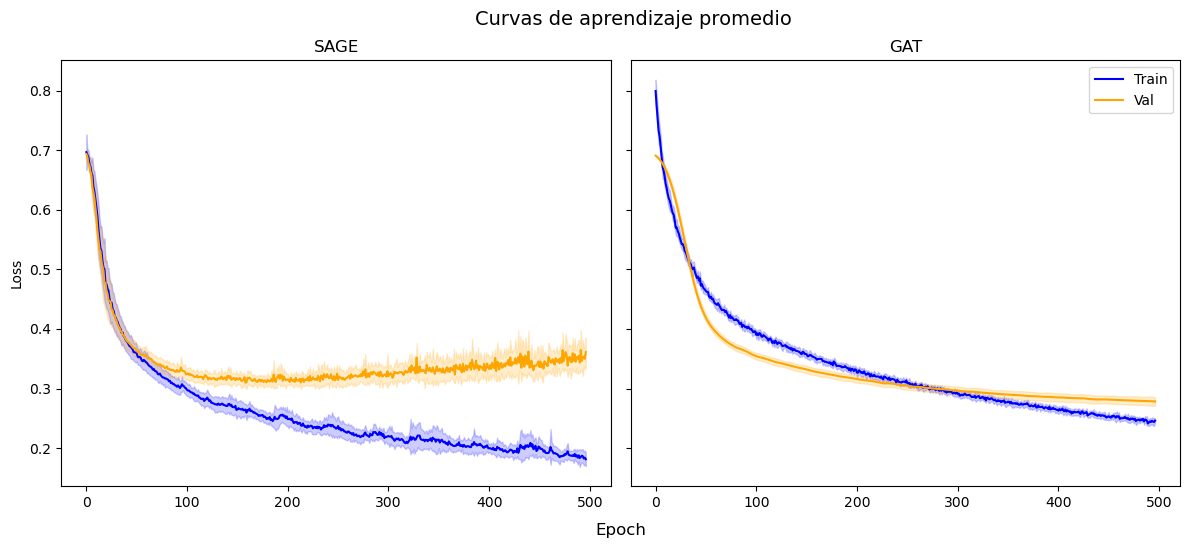

In [50]:
fig, axes = plt.subplots(1,2,figsize=(12,5),sharex=True, sharey=True)
plot_mean_loss_curves(sage_curves,axes[0])
axes[0].set_ylabel("Loss")
axes[0].set_title("SAGE")
plot_mean_loss_curves(gat_curves, axes[1])
axes[1].set_title("GAT")
fig.text(x=0.4, y=1, s="Curvas de aprendizaje promedio", fontsize=14)
fig.text(x=0.5,y=-0.02, s="Epoch", fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()